<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 7.5 MB/s 
  Created wheel for pyod: filename=pyod-1.0.4-py3-none-any.whl size=165073 sha256=4aebda2fbb8b805f0408a3d544e233b893cf6bc223ffe2a44b691762b3ad15a6
  Stored in directory: /root/.cache/pip/wheels/3d/48/a8/87d61660791c7e6b0f5c3068da7fb17ade7fdc041e864fe053
Successfully built pyod


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)
assert test_df.shape == (449919, 52)


train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# following [Zhihan Li et al. KDD21] & [Dan Li. ICANN. 2019]
# fow SWaT data, due to the cold start of the system, starting point is 21600
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

Model Prediction

In [50]:
from  pyod.models.deep_svdd import DeepSVDD
model = DeepSVDD(preprocessing = False,epochs=100, batch_size=128, hidden_neurons=[64, 32])
model.fit(train_scale)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 51)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                3264      
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_3 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_3 (TFOpL  (None,)                  0         
 ambda)                                                    

DeepSVDD(batch_size=128,
     c=array([0.10104, 0.3643 , 0.1    , 0.36407, 0.28572, 0.1    , 0.1    ,
       0.1    , 0.20218, 0.1    , 0.1    , 0.1    , 0.39275, 0.83632,
       0.2779 , 0.1    , 0.1    , 0.49126, 0.1    , 0.4617 , 0.18332,
       0.     , 0.37663, 0.14527, 0.1    , 0.2154 , 0.1    , 0.     ,
       0.20231, 0.59263, 0.1    , 0.61894], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=100,
     hidden_activation='relu', hidden_neurons=[64, 32], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=False,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)

In [51]:
print(model.model_)

In [52]:
# get outlier scores
train_scores = model.decision_scores_  # raw outlier scores on the train data
test_scores = model.decision_function(test_scale)  # predict raw outlier scores on test

In [53]:
pd.DataFrame(test_scores).describe()

,0
count,449919.000000
mean,1264.348022
std,4477.229980
min,0.000001
25%,0.032573
50%,0.942245
75%,1.793934
max,18019.433594


In [54]:
pd.DataFrame(train_scores).describe()

,0
count,475200.000000
mean,0.032012
std,0.003459
min,0.000184
25%,0.031207
50%,0.032207
75%,0.032835
max,1.732697


In [55]:
fpr, tpr, _ = metrics.roc_curve(label,  test_scores)
auc = metrics.roc_auc_score(label,  test_scores)

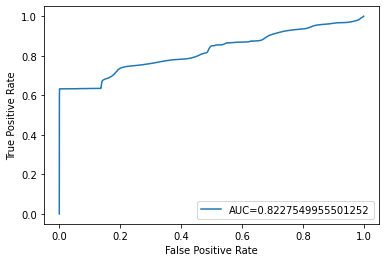

In [56]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [57]:
#normalise error score
min_train = min(train_scores)
max_train = max(train_scores)
norm_train = (train_scores-min_train)/(max_train-min_train)

In [58]:
norm_test = (test_scores - min_train)/(max_train-min_train)

In [59]:
df_error_train = pd.DataFrame(norm_train,columns = ['error'])
df_error_test = pd.DataFrame(norm_test,columns = ['error'])

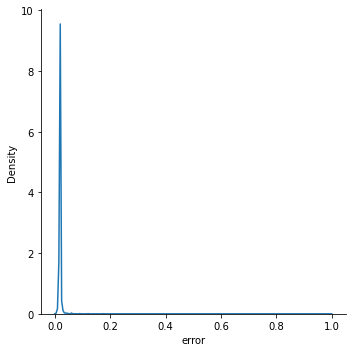

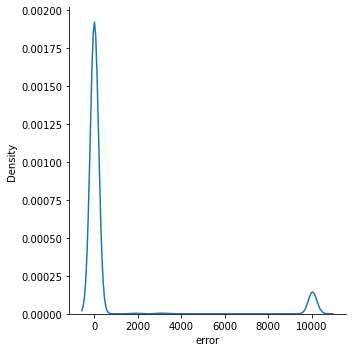

In [60]:
sns.displot(df_error_train, x="error",kind="kde")
sns.displot(df_error_test, x="error",kind="kde")

In [338]:
threshold= np.percentile(norm_test,92)
threshold

12.157069168090818

In [339]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    pred_label[i:i+time_window] = 0
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
  return pred_label

In [340]:
time_window = 10
pred_label = pred_labels_timewindow(norm_test,threshold,time_window)

In [341]:
print(metrics.classification_report(label,pred_label))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    395298
           1       0.94      0.63      0.76     54621

    accuracy                           0.95    449919
   macro avg       0.95      0.81      0.87    449919
weighted avg       0.95      0.95      0.95    449919



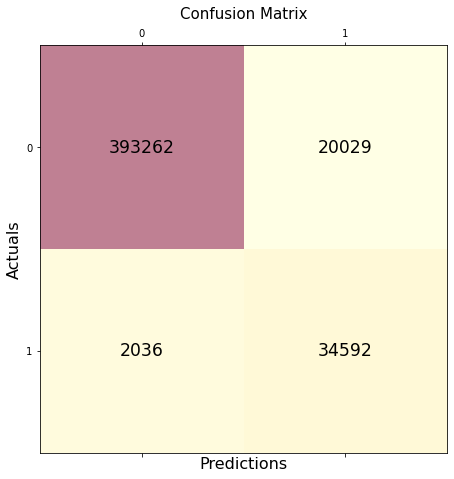

In [342]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label,pred_label)

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cm, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cm.shape[0]):
    for n in range(cm.shape[1]):
        px.text(x=m,y=n,s=cm[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [343]:
time_label = pd.DataFrame(pred_label, index= test_df.index, columns = ['pred'])

In [344]:
time_label['label'] = label
time_label.reset_index(inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label.Timestamp)

true anomaly

In [69]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [70]:
start_time = true_anomaly['Start Time'][~true_anomaly["End Time"].isnull()]
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [71]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [72]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [73]:
len(start_time) #there are 36 attack

36

In [345]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [346]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'normal/attack')

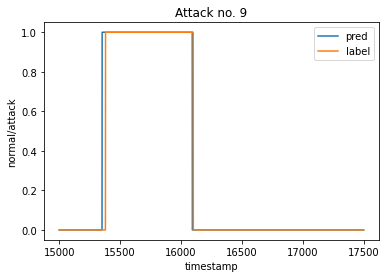

In [351]:
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["pred"])
plt.plot(time_label.loc[15000:17500].index,time_label.loc[15000:17500]["label"])
plt.title('Attack no. 9')
plt.legend(["pred", "label"])
plt.xlabel("timestamp")
plt.ylabel("normal/attack")

Text(0.5, 1.0, 'attack 1-8')

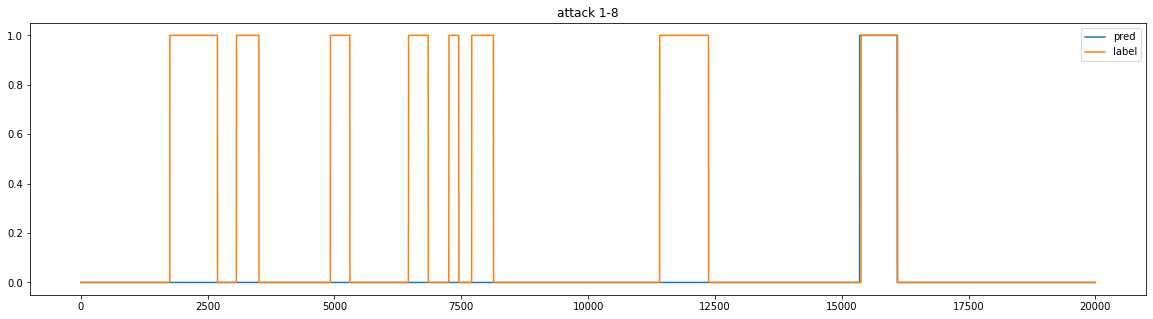

In [348]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[:20000],time_label["pred"][:20000])
plt.plot(time_label.index[:20000],time_label["label"][:20000])
plt.legend(["pred", "label"])
plt.title('attack 1-8')

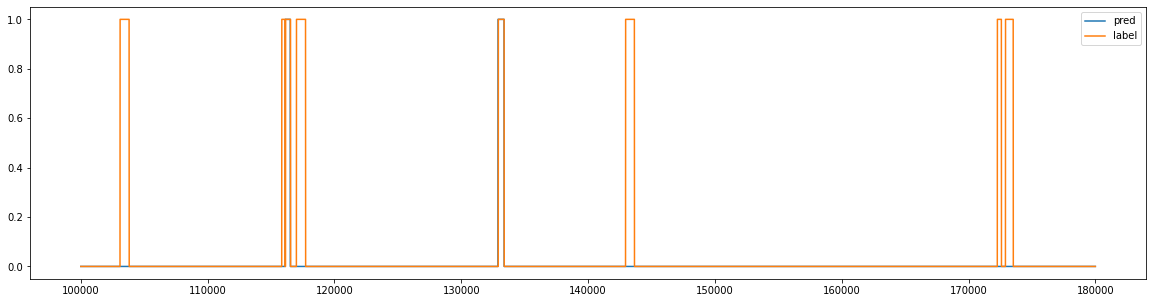

In [355]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[100000:180000],time_label["pred"][100000:180000])
plt.plot(time_label.index[100000:180000],time_label["label"][100000:180000])
plt.legend(["pred", "label"])

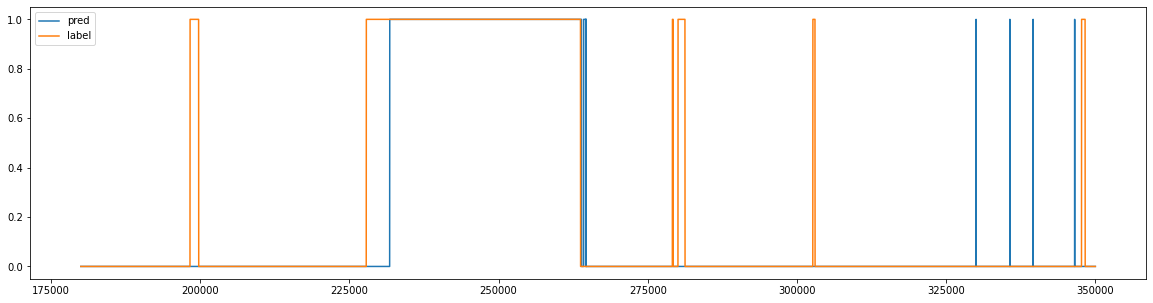

In [356]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[180000:350000],time_label["pred"][180000:350000])
plt.plot(time_label.index[180000:350000],time_label["label"][180000:350000])
plt.legend(["pred", "label"])

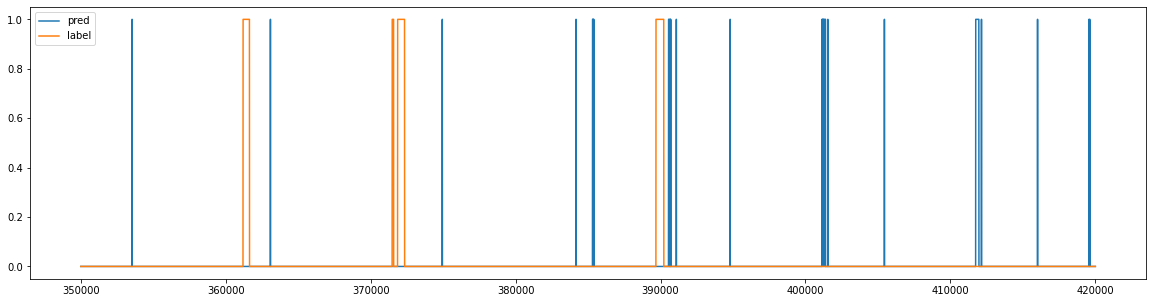

In [360]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[350000:420000],time_label["pred"][350000:420000])
plt.plot(time_label.index[350000:420000],time_label["label"][350000:420000])
plt.legend(["pred", "label"])

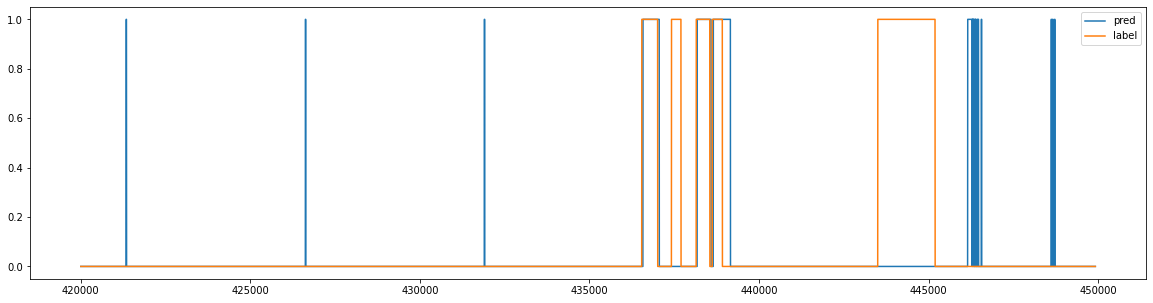

In [366]:
ax = plt.figure(figsize=(20, 5))
plt.plot(time_label.index[420000:],time_label["pred"][420000:])
plt.plot(time_label.index[420000:],time_label["label"][420000:])
plt.legend(["pred", "label"])

Apply XAI

##CASE STUDY attack no.1

### SHAP

In [ ]:
!pip install shap

In [43]:
import shap

In [237]:
# def shap_explanation_attack(data,idx_start,idx_end):
#   shap_values = []
#   X_train_summary = shap.kmeans(train_scale, 50)
#   explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary, link="logit")
#   for i in range (len(idx_start)):
#     sample = shap.sample(data[idx_start[i]:idx_end[i]], 50)
#     shap_values.append(explainer.shap_values(X=sample, nsamples=100))
#     # print(shap_values)
#     # break
#   return shap_values


In [397]:
X_train_summary = shap.sample(train_scale, 50)
shap_explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary, link="logit")

In [398]:
#attack no.1
#sample data  in attack no.1 for 100 instance
sample = shap.sample(test_scale[idx_start[0]:idx_end[0]], 100)

In [ ]:
shap_values_1 = shap_explainer.shap_values(X=sample, nsamples=100)

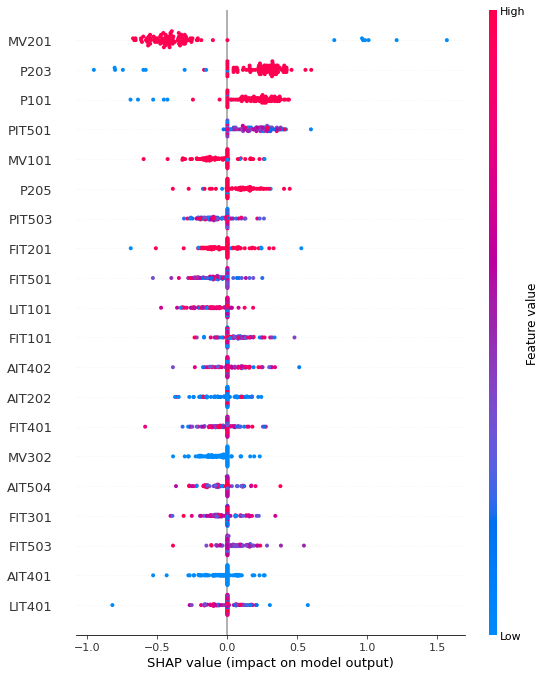

In [400]:
shap.initjs()
shap.summary_plot(shap_values_1, sample)

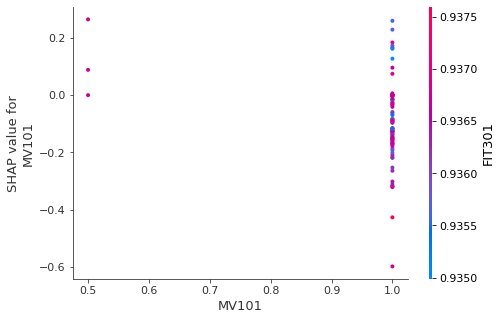

In [524]:
shap.dependence_plot("MV101", shap_values_1, sample)

### LIME

In [390]:
!pip install lime --quiet

     |████████████████████████████████| 275 kB 8.7 MB/s 


In [517]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [409]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')

In [434]:
def lime_explainer(sample):
  score = []
  n_sample = len(sample)
  for i in (range(n_sample)):
    score.append(explainer.explain_instance(sample.iloc[i], model.decision_function, num_features=51))
  return score

In [ ]:
exp = lime_explainer(sample)

In [513]:
a = explainer.explain_instance(sample.iloc[10], model.decision_function, num_features=10)

Intercept 0.6280631003378576
Prediction_local [0.07959935]
Right: 0.032799147


In [515]:
a.show_in_notebook(show_table=False)

In [522]:
sp_obj = submodular_pick.SubmodularPick(explainer, sample.values, model.decision_function, num_features=20,num_exps_desired=10)

Requested sample size larger than
                              size of input data. Using all data


Intercept 0.5637629438067369
Prediction_local [0.08642116]
Right: 0.032729432
Intercept 0.6841074579851749
Prediction_local [0.13339002]
Right: 0.032659866
Intercept 0.7177505385637576
Prediction_local [0.04298069]
Right: 0.03251967
Intercept 0.5836245805025755
Prediction_local [0.05059278]
Right: 0.03233327
Intercept 0.6863210806921572
Prediction_local [0.02239843]
Right: 0.032539114
Intercept 0.6006974758280348
Prediction_local [0.07450387]
Right: 0.032655448
Intercept 0.656361858103587
Prediction_local [0.07716635]
Right: 0.032015096
Intercept 0.6686551272451589
Prediction_local [0.05703844]
Right: 0.032738507
Intercept 0.5879817174241964
Prediction_local [0.094096]
Right: 0.032494083
Intercept 0.6662610735307337
Prediction_local [0.0241652]
Right: 0.032592047
Intercept 0.5262520937280912
Prediction_local [0.04792208]
Right: 0.032561578
Intercept 0.15818086562403022
Prediction_local [0.39858588]
Right: 0.032541677
Intercept 0.17902965138145682
Prediction_local [0.4552727]
Right: 0.0

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

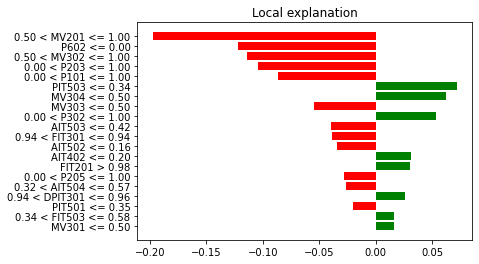

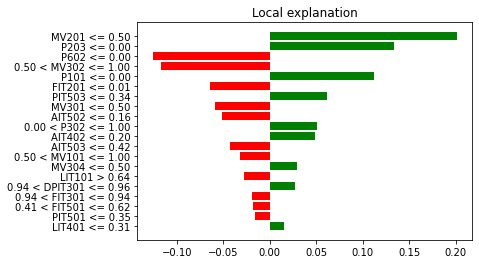

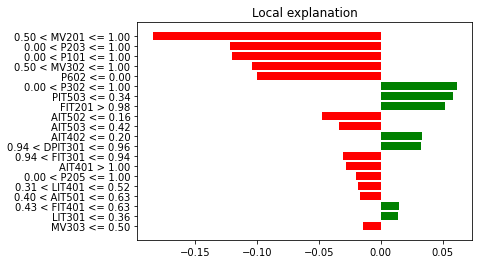

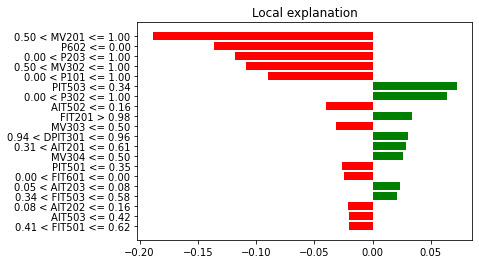

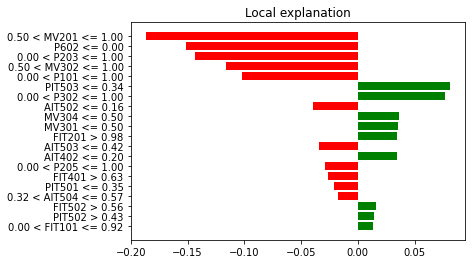

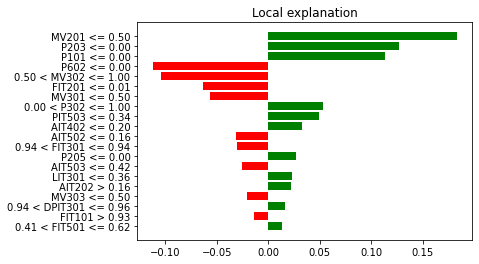

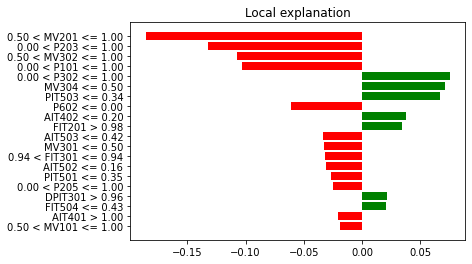

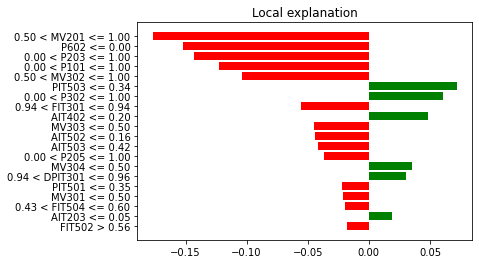

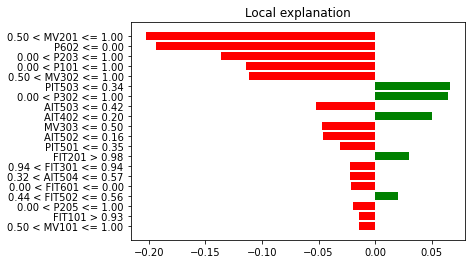

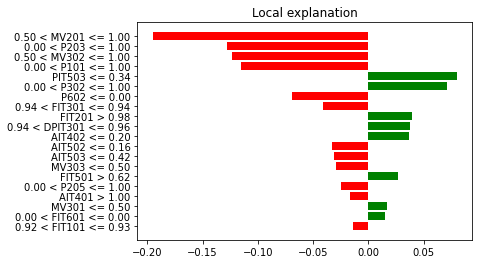

In [523]:
[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

###IntegratedGradients

In [ ]:
!pip install alibi[tensorflow]

In [104]:
from alibi.explainers import IntegratedGradients
import tensorflow as tf

In [117]:
ig  = IntegratedGradients(model.model_,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

In [571]:
explanation = ig.explain(sample.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample))

In [572]:
attributions = explanation.attributions

In [600]:
ig_result = pd.DataFrame(np.mean(attributions[0],axis=0), index= train_scale.columns, columns = ["result"])

In [602]:
ig_result.sort_values(by = ["result"])

,result
PIT503,-0.030358
FIT101,-0.011432
DPIT301,-0.010559
PIT502,-0.005548
FIT401,-0.002783
AIT201,-0.002288
LIT401,-0.001861
AIT503,-0.001777
FIT201,-0.001020
AIT202,-0.000105


In [127]:
# type(model).__mro__

(pyod.models.deep_svdd.DeepSVDD, pyod.models.base.BaseDetector, object)

In [554]:
pip install alibi[tensorflow]

In [85]:
from alibi.explainers import CEM

In [84]:
print(model.prediction_fun)

DeepSVDD(batch_size=128,
     c=array([0.1    , 0.1    , 1.11252, 0.11552, 0.     , 0.1    , 0.42432,
       0.37247, 0.37362, 0.     , 0.1    , 0.1    , 0.1    , 0.1    ,
       0.66449, 0.1    , 0.1    , 0.1    , 0.26722, 0.24454, 0.11259,
       0.1    , 0.2306 , 0.1    , 0.16838, 0.52021, 0.1    , 0.26156,
       0.1    , 0.53967, 0.11105, 0.52646], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=100,
     hidden_activation='relu', hidden_neurons=[64, 32], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=False,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)


In [87]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + train_scale.shape[1:]  # instance shape
kappa = .2  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (train_scale.to_numpy().min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 train_scale.to_numpy().max(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # gradient clipping
lr_init = 1e-2  # initial learning rate

In [91]:
cem = CEM(model.decision_function, mode, shape, kappa=kappa, beta=beta,
          feature_range=feature_range, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr_init)
cem.fit(train_scale, no_info_type='median')

IndexError: ignored

In [80]:
%debug

> /usr/local/lib/python3.7/dist-packages/alibi/explainers/integrated_gradients.py(825)__init__()
    823         self.model = model
    824 
--> 825         if self.model.inputs is None:
    826             self._has_inputs = False
    827         else:

ipdb> inputs
*** NameError: name 'inputs' is not defined
ipdb> self.model.inputs
*** AttributeError: 'numpy.ndarray' object has no attribute 'inputs'
ipdb> u
> <ipython-input-79-958c28e5adc4>(1)<module>()
----> 1 ig = IntegratedGradients(model=model.decision_function(test_scale))
      2 # explanation = ig.explain(X)

ipdb> c


In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
train = train_df
train['label'] = 0

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=train.columns, class_names=['label'],
                                                   verbose=True, mode='regression',
                                                   random_state = 42)